In [65]:
import pandas as pd
from modules import Agent,Model
from DCAStrategy import DCAAgent
from LSStrategy import LSSAgent
import numpy as np
import torch
import pickle
device = "cuda" if torch.cuda.is_available() else "cpu"
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing import Feature_Extractor, data_preprocessing


In [66]:
symbol = "STB"
from_date ="2023-11-03"
to_date = "2024-05-17"
# from_date ="2023-05-18"
# to_date = "2024-06-18"
# from_date ="2023-01-15"
# to_date = "2023-12-01"
skip =1

In [67]:
df = pd.read_csv(f'DataTrainLSTM/{symbol}.csv')

DCA None LSTM


c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0.00000000e+000 6.12482994e-316 1.00000000e+000]
[1. 

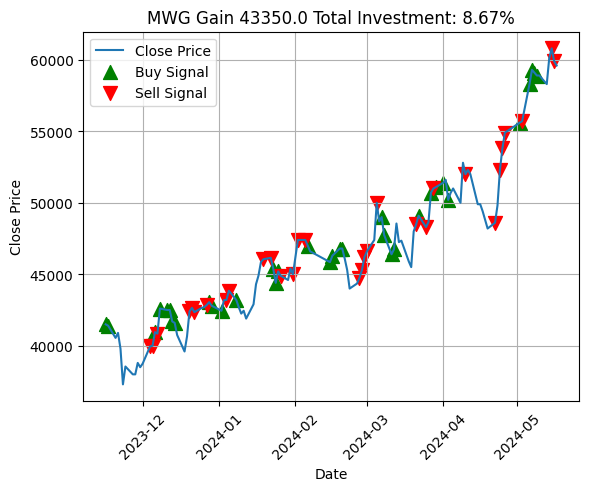

In [68]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}RAWpredictions_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}RAWpredictions_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 500000
skip = 1
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
result = result[result['status'] != 'data not enough to trade']
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA with LSTM

c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[4.01251626e-263 0.00000000e+000 1.00000000e+000]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 

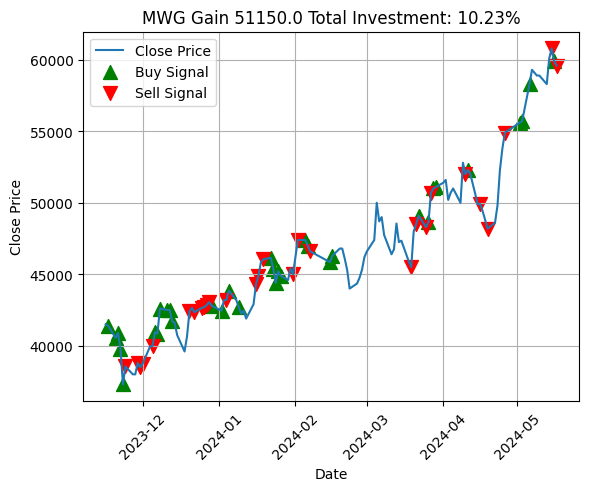

In [69]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}LSTMpredictions_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}LSTMpredictions_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 500000
skip = 1
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
result = result[result['status'] != 'data not enough to trade']
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA LSTM Attention


c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0.00000000e+000 1.10646958e-280 1.00000000e+000]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1.00000000e+00 0.00000000e+00 2.22948814e-35]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[

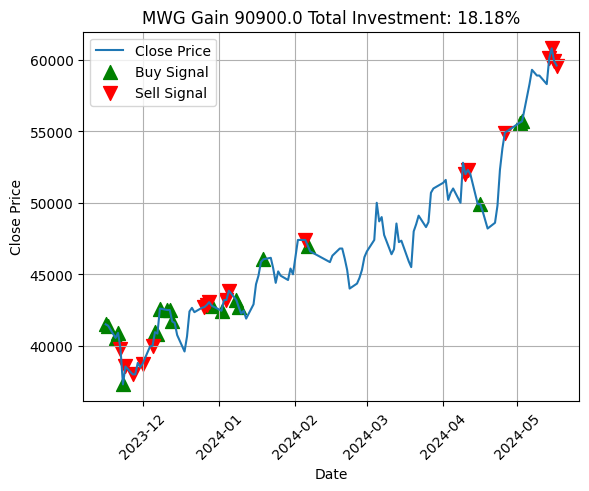

In [70]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}LSTMAttentionpredictions_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}LSTMAttentionpredictions_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 500000
skip = 1
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
result = result[result['status'] != 'data not enough to trade']
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

DCA with LSTM GRU


c:\Users\hotua\anaconda3\envs\venv\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 0. 1.]
[0. 1. 0.]
[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]
[0. 1. 0.]

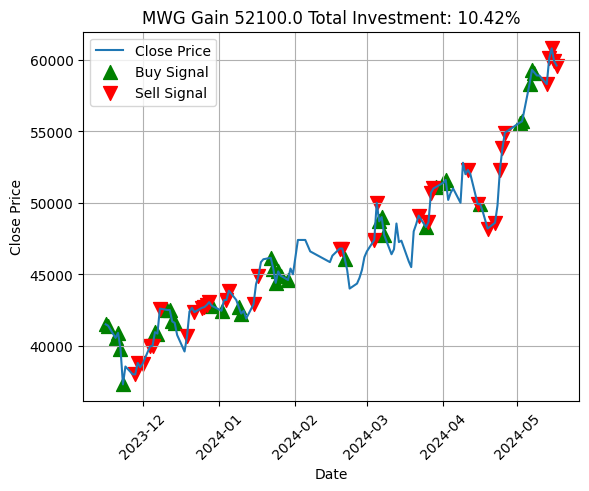

In [71]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}LSTMGRUpredictions_scaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}LSTMGRUpredictions_model.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 500000
skip = 1
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
result = result[result['status'] != 'data not enough to trade']
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

AD NONE LSTM

In [72]:
df['Date'] = pd.to_datetime(df['Date'])
df_init = df[['Close']]  
df_init = data_preprocessing(df_init, Feature_Extractor)
real_trend = df_init['Close'].tolist()
parameters = [df_init[cl].tolist() for cl in df_init.columns]
minmax = pickle.load(open(f"checkpoint/{symbol}RAWpredictions_DCAscaler.pkl", 'rb'))
scaled_parameters = minmax.transform(np.array(parameters).T).T.tolist()
with open(f"checkpoint/{symbol}RAWpredictions_DCAmodel.pkl", 'rb') as fopen:
    model = pickle.load(fopen)
# initial_money = np.max(parameters[0]) * 3
initial_money= 500000
skip = 1
from_date = pd.to_datetime(from_date)
to_date = pd.to_datetime(to_date)
df = df[['Date', 'Close']]
#Preprocess Dataframe
df = data_preprocessing(df, Feature_Extractor)
selected_data = df.loc[(df['Date'] >= from_date) & (df['Date'] <= to_date),:]
data_list = selected_data.values.tolist()
agent = Agent(model = model,
                timeseries = scaled_parameters,
                skip = skip,
                initial_money = initial_money,
                real_trend = real_trend,
                minmax = minmax,
                window_size = 10)
trade_results = []
for row in data_list:
    #ensure first column is Date
    date = row[0]
    value = row[1:]
    result = agent.trade(value, date = date)
    trade_results.append(result)
result = pd.DataFrame(trade_results)

# Convert the 'date' column to datetime format
result['date'] = pd.to_datetime(result['date'])
result = result[result['status'] != 'data not enough to trade']
df_action_2 = result[result['action'] == 2]

# Sắp xếp DataFrame theo timestamp hoặc date để đảm bảo lấy hàng cuối cùng
df_action_2_sorted = df_action_2.sort_values(by='date')

# Lấy giá trị total_investment của hàng cuối cùng
last_total_investment = df_action_2_sorted.iloc[-1]['total_investment']
df_sorted = result.sort_values(by='date')

# Lấy giá trị total của hàng cuối cùng
last_total = df_sorted.iloc[-1]['total']
investmentvalue = (last_total-initial_money)/initial_money *100
total_gain = result['gain'].sum()
investGain = total_gain/initial_money *100
print(last_total_investment)
print(investmentvalue)
print(total_gain)
print(investGain)

# Mark buy and sell actions
buy_signals = result[result['action'] == 1]
sell_signals = result[result['action'] == 2]
plt.plot(result['date'], result['close'], linestyle='-', label='Close Price')

plt.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='g', s=100, label='Buy Signal')
plt.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='r', s=100, label='Sell Signal')

# Customize the plot
plt.title(f'{symbol} Gain {round(total_gain,2)} Total Investment: {round(investGain,2)}%')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint/MWGRAWpredictions_DCAscaler.pkl'